# Model Training

### Imports

In [45]:
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
import sagemaker
from sagemaker import PCA, KMeans, get_execution_role, Session
from sklearn.metrics import silhouette_score
import time
from sagemaker.model import Model
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

## Load Training Dataset from S3

In [46]:
train_df = pd.read_csv('s3://team6datasets/splitDatasets/train.csv')

## Sagemaker Session and Role

In [47]:
# Define the SageMaker session and role
sagemaker_session = Session()
role = get_execution_role()

## Feature Scaling

In [48]:
# Feature Scaling
scaler  = StandardScaler()

# Convert to float32 for memory efficiency
scaled_data = scaler.fit_transform(train_df.astype('float32'))

## Dimensionality Reduction with Incremental PCA

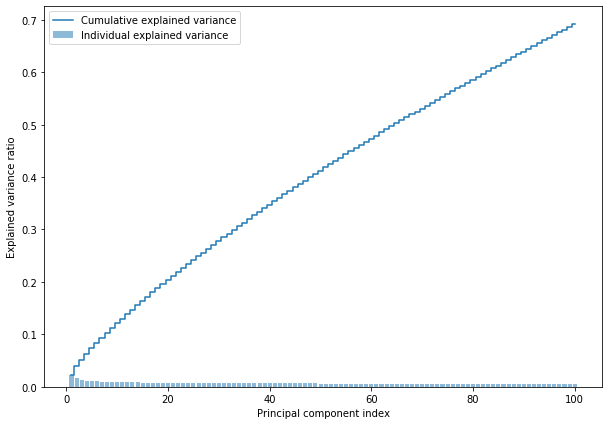

In [49]:
# Use IncrementalPCA for dimensionality reduction
ipca = IncrementalPCA(n_components=100, batch_size=150)
ipca.fit(scaled_data)

# Plot the explained variance ratio
plt.figure(figsize=(10, 7))
plt.bar(range(1, ipca.n_components_ + 1), ipca.explained_variance_ratio_, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, ipca.n_components_ + 1), np.cumsum(ipca.explained_variance_ratio_), where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [50]:
# Define PCA model
pca_estimator = PCA(role=get_execution_role(),
                    instance_count = 1,
                    instance_type = 'ml.c4.xlarge',
                    num_components = 10)

# Fit PCA model
pca_estimator.fit(pca_estimator.record_set(scaled_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2024-04-02 06:43:10 Starting - Starting the training job...
2024-04-02 06:43:33 Starting - Preparing the instances for trainingProfilerReport-1712040190: InProgress
...
2024-04-02 06:44:10 Downloading - Downloading input data......
2024-04-02 06:44:54 Downloading - Downloading the training image......
2024-04-02 06:46:06 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[04/02/2024 06:46:19 INFO 140278710449984] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', 

## Model Training with KMeans Algorithm

In [65]:
# Define hyperparameters for KMeans models
hyperparameter_sets = [
    {'k': 5, 'init_method': 'random'},
    {'k': 10, 'init_method': 'random'},
    {'k': 15, 'init_method': 'random'},
    {'k': 20, 'init_method': 'random'}
]

# Run trials for KMeans models
role = get_execution_role()
sagemaker_session = Session()

for hyperparameters in hyperparameter_sets:
    k_value = hyperparameters['k']
    output_path = f's3://team6datasets/kmeans_model_output/'
    
    kmeans = KMeans(role=role,
                    instance_count=1,
                    instance_type='ml.c4.xlarge',
                    k=k_value,
                    output_path=output_path)  # Specify the output path during initialization
    
    # Fit the model
    kmeans.fit(kmeans.record_set(scaled_data), job_name=f"kmeans-{k_value}")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2024-04-02 07:53:02 Starting - Starting the training job...
2024-04-02 07:53:26 Starting - Preparing the instances for trainingProfilerReport-1712044381: InProgress
...
2024-04-02 07:53:51 Downloading - Downloading input data......
2024-04-02 07:54:46 Downloading - Downloading the training image......
2024-04-02 07:55:54 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/02/2024 07:56:02 INFO 140416586995520] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2024-04-02 07:57:00 Starting - Starting the training job...
2024-04-02 07:57:26 Starting - Preparing the instances for trainingProfilerReport-1712044620: InProgress
...
2024-04-02 07:57:56 Downloading - Downloading input data......
2024-04-02 07:58:46 Downloading - Downloading the training image......
2024-04-02 07:59:57 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/02/2024 08:00:06 INFO 139770627565376] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2024-04-02 08:01:02 Starting - Starting the training job...
2024-04-02 08:01:26 Starting - Preparing the instances for trainingProfilerReport-1712044862: InProgress
...
2024-04-02 08:01:52 Downloading - Downloading input data...
2024-04-02 08:02:32 Downloading - Downloading the training image.........
2024-04-02 08:03:53 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/02/2024 08:04:03 INFO 139828750333760] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2024-04-02 08:05:00 Starting - Starting the training job...
2024-04-02 08:05:27 Starting - Preparing the instances for trainingProfilerReport-1712045100: InProgress
...
2024-04-02 08:05:54 Downloading - Downloading input data......
2024-04-02 08:06:47 Downloading - Downloading the training image......
2024-04-02 08:07:51 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/02/2024 08:08:03 INFO 140408741328704] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_

## Calculate Silhouette Scores for KMeans Models

### List objects in S3 folder for KMeans

In [66]:
# Initialize S3 client
s3 = boto3.client('s3')

# Bucket name and prefix
bucket_name = 'team6datasets'
prefix = 'kmeans_model_output/'

# List objects in the bucket with the given prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Extract folder names from the object keys
folders = [obj['Prefix'].split('/')[-2] for obj in response.get('CommonPrefixes', [])]

print("Folders found:", folders)

Folders found: []


In [69]:
# Calculate Silhouette Scores for KMeans Models
def calculate_silhouette_score(model_data, hyperparameters):
    # Define the SageMaker model
    model = Model(
        model_data=model_data,
        image_uri=sagemaker.image_uris.retrieve("kmeans", region),
        role=role,
        sagemaker_session=sagemaker_session
    )
    
    # Deploy the model
    predictor = model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")
    
    # Set serializer and deserializer
    predictor.serializer = CSVSerializer()
    predictor.deserializer = JSONDeserializer()
    
    # Make predictions
    results = predictor.predict(scaled_data.tolist())
    cluster_labels = np.array([r['closest_cluster'] for r in results['predictions']])
    
    # Calculate Silhouette Score
    score = silhouette_score(scaled_data, cluster_labels)
    
    # Delete the endpoint
    predictor.delete_endpoint()
    
    return score

# Get model artifacts and hyperparameters
model_artifacts = [
    {
        "model_data": f"s3://{bucket_name}/kmeans_model_output/kmeans-{hyperparameters['k']}/output/model.tar.gz",
        "hyperparameters": hyperparameters
    }
    for hyperparameters in hyperparameter_sets
]

print("Model artifacts:", model_artifacts)  # Debug statement

# Calculate silhouette scores
silhouette_scores = [calculate_silhouette_score(model['model_data'], model['hyperparameters']) for model in model_artifacts]

print("Silhouette scores:", silhouette_scores)

Model artifacts: [{'model_data': 's3://team6datasets/kmeans_model_output/kmeans-5/output/model.tar.gz', 'hyperparameters': {'k': 5, 'init_method': 'random'}}, {'model_data': 's3://team6datasets/kmeans_model_output/kmeans-10/output/model.tar.gz', 'hyperparameters': {'k': 10, 'init_method': 'random'}}, {'model_data': 's3://team6datasets/kmeans_model_output/kmeans-15/output/model.tar.gz', 'hyperparameters': {'k': 15, 'init_method': 'random'}}, {'model_data': 's3://team6datasets/kmeans_model_output/kmeans-20/output/model.tar.gz', 'hyperparameters': {'k': 20, 'init_method': 'random'}}]
--------------------!

AttributeError: 'NoneType' object has no attribute 'serializer'